In [ ]:
import warnings
!pip install lightgbm
!pip install lazypredict

In [321]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor
import lazypredict
from lazypredict.Supervised import LazyRegressor
from tqdm import tqdm
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [322]:
# Open a file contaning Smiles

data = pd.read_csv("/Users/ajaniharesh/Desktop/MLTest/Solublity/ESOL.txt")

In [323]:
data=data.rename(columns={'measured log(solubility:mol/L)':'Exp_LogS','ESOL predicted log(solubility:mol/L)':'Pre_LogS'})

In [324]:
data.shape

(1144, 4)

In [325]:
# Null vaules for Smiles
data.SMILES.isnull().sum()

0

In [326]:
#remove Null Vaules
data.dropna(inplace=True)

In [327]:
data.shape

(1144, 4)

In [328]:
data

,Compound ID,Exp_LogS,Pre_LogS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.79,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.23,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.55,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.96,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.08,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.14,-1.45,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.92,-4.38,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.89,-3.91,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.79,-3.64,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


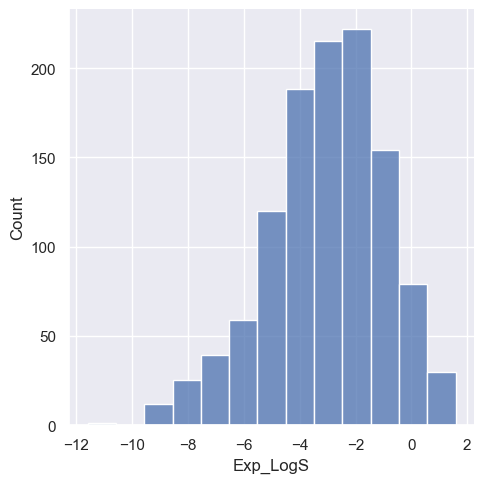

In [329]:
# Remove Outliers, which can not useful in ML
# Generate Histogram for LogS vaules distribution
sn.set_theme()
sn.displot(data=data, x="Exp_LogS", binwidth=1)

<Axes: xlabel='Exp_LogS'>

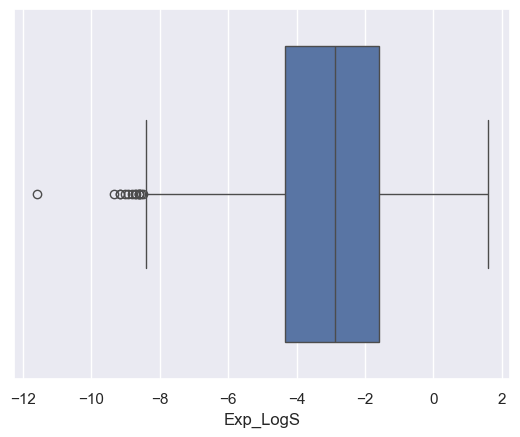

In [330]:
#Boxplot
sn.boxplot(data=data, x='Exp_LogS')

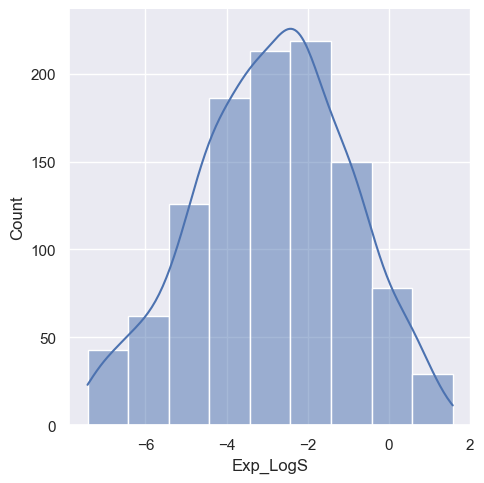

In [331]:
data_new = data[data.Exp_LogS.apply(lambda x:x> -7.5 and x< 1.7)]
sn.displot(data=data_new, x="Exp_LogS", binwidth=1, kde=True)

<Axes: xlabel='Exp_LogS'>

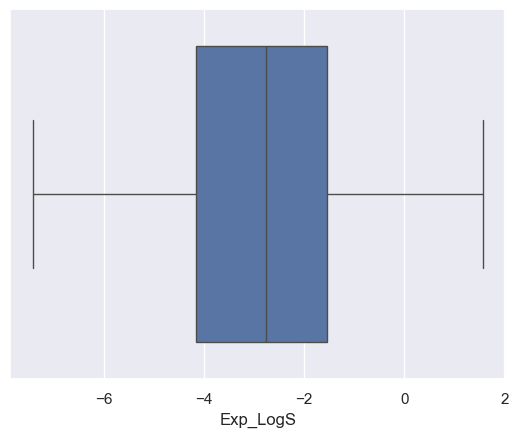

In [332]:
sn.boxplot(data=data_new, x='Exp_LogS')

In [333]:
data_new.shape

(1106, 4)

In [334]:
data_new

,Compound ID,Exp_LogS,Pre_LogS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.79,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.23,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.55,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.96,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.08,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.14,-1.45,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.92,-4.38,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.89,-3.91,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.79,-3.64,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [335]:
# Remove the Duplicates Smiles or Structures

# generate canonical SMILES

def canonical_SMILES(smiles):
    canon_smi = [Chem.CanonSmiles(smi) for smi in smiles]
    return canon_smi

In [336]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_new.SMILES)

# Replace SMILES column wit Canonical SMILES
data_new["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = data_new[data_new['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

27

In [337]:
# Filter the duplicates smiles and sort them based on smiles

data_new[data_new['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,Exp_LogS,Pre_LogS,SMILES
192,2-Bromonapthalene,-4.40,-4.43,Brc1ccc2ccccc2c1
191,2-bromonaphthalene,-4.40,-4.43,Brc1ccc2ccccc2c1
55,"1,8-Cineole",-1.74,-2.58,CC12CCC(CC1)C(C)(C)O2
674,eucalyptol,-1.64,-2.58,CC12CCC(CC1)C(C)(C)O2
392,Androsterone,-4.40,-3.88,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
629,Epiandrosterone,-4.16,-3.88,CC12CCC3C(CCC4CC(O)CCC43C)C1CCC2=O
288,3-Methyl-2-pentanol,-0.72,-1.38,CCC(C)CCO
289,3-Methyl-2-pentanol,-0.71,-1.31,CCC(C)CCO
338,5-Ethyl-5-isopropylbarbituric acid,-2.15,-1.60,CCC1(C(C)C)C(=O)NC(=O)NC1=O
981,probarbital,-2.21,-1.60,CCC1(C(C)C)C(=O)NC(=O)NC1=O


In [338]:
# Drop rows that contain duplicate SMILES and keep the first Structure
data_cleaned = data_new.drop_duplicates(subset=['SMILES'], keep='first')
len(data_cleaned)

1079

In [339]:
data_cleaned

,Compound ID,Exp_LogS,Pre_LogS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.79,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.23,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.55,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.96,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.08,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.14,-1.45,CNC(=O)C(C)SCCSP(=O)(OC)OC
1140,Vinclozolin,-4.92,-4.38,C=CC1(C)OC(=O)N(c2cc(Cl)cc(Cl)c2)C1=O
1141,Warfarin,-3.89,-3.91,CC(=O)CC(c1ccccc1)c1c(O)c2ccccc2oc1=O
1142,Xipamide,-3.79,-3.64,Cc1cccc(C)c1NC(=O)c1cc(S(N)(=O)=O)c(Cl)cc1O


In [ ]:
#Calculate RDkit Molecular Descriptors, which are molecular features

def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 210 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned['SMILES'])



In [340]:
# Put the descriptors to dataframe
Dataset_with_210_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
Dataset_with_210_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,6.62,6.62,2.05,-2.29,0.49,19.33,167.85,165.83,165.89,38,...,0,0,0,0,0,0,0,0,0,0
1,6.52,6.52,2.15,-2.52,0.45,23.40,133.41,130.38,131.93,32,...,0,0,0,0,0,0,0,0,0,0
2,6.66,6.66,2.17,-2.17,0.53,19.33,167.85,165.83,165.89,38,...,0,0,0,0,0,0,0,0,0,0
3,6.61,6.61,2.27,-2.39,0.48,23.40,133.41,130.38,131.93,32,...,0,0,0,0,0,0,0,0,0,0
4,11.54,11.54,3.69,-4.23,0.55,14.25,187.38,187.38,185.90,50,...,0,0,0,0,0,0,0,0,0,0


In [341]:
Dataset_with_210_descriptors.shape

(1079, 210)

In [342]:
#Split the Compounds for Training and Validation set
# Train-validation split
X_train, X_valid, y_train, y_valid = train_test_split(Dataset_with_210_descriptors,
                                                      data_cleaned.Exp_LogS,
                                                      test_size=0.1,random_state=42)

In [343]:
y_train.shape

(971,)

In [344]:
X_train.shape

(971, 210)

In [345]:
X_valid.shape

(108, 210)

In [346]:
y_valid.shape

(108,)

In [347]:
valid_y = pd.DataFrame(y_valid)
valid_y

,Exp_LogS
452,-3.33
585,-0.09
778,-6.00
625,-2.17
882,-3.17
...,...
1060,-4.74
357,-6.24
621,-3.35
563,-3.59


In [348]:
valid_x = pd.DataFrame(X_valid)
valid_x

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
423,8.69,8.69,0.03,-0.15,0.79,12.64,276.91,273.89,274.86,56,...,0,0,0,0,0,0,0,0,0,0
548,6.91,6.91,3.26,-3.36,0.48,48.80,74.12,64.04,74.07,32,...,0,0,0,0,0,0,0,0,0,0
730,14.27,14.27,2.33,-5.77,0.67,84.34,404.55,368.26,404.26,162,...,0,0,0,0,0,0,0,0,0,0
588,11.45,11.45,0.22,-3.32,0.74,24.31,180.21,168.11,180.09,70,...,0,0,0,0,0,0,0,0,0,1
830,13.08,13.08,0.96,-4.42,0.72,105.00,222.33,200.16,222.17,90,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,13.44,13.44,2.81,-5.66,0.73,117.81,290.45,260.21,290.22,118,...,0,0,0,0,0,0,0,0,0,0
336,8.36,8.36,0.18,-4.86,0.41,24.59,466.48,446.32,465.99,148,...,0,0,0,0,0,0,0,0,0,0
584,12.99,12.99,0.25,-5.36,0.62,28.53,299.29,285.18,299.04,102,...,0,0,0,0,0,0,0,0,0,0
527,19.92,19.92,2.16,-6.20,0.67,88.18,392.47,363.24,392.20,154,...,0,0,0,0,0,0,0,0,0,0


In [349]:
combine=pd.concat([valid_x, valid_y], axis=1)

In [350]:
list(combine.columns)

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',


In [351]:
# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [352]:
X_valid_scaled.shape

(108, 210)

In [353]:
#Select Machine Learning Models
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(X_train_scaled, X_valid_scaled, y_train, y_valid)

 98%|█████████████████████████████████████████▉ | 41/42 [00:15<00:00,  2.41it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15196
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 144
[LightGBM] [Info] Start training from score -2.866933


100%|███████████████████████████████████████████| 42/42 [00:16<00:00,  2.59it/s]


In [354]:
#The top three models
prediction_tests[:]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,20918919000539050853875376027716130807028593459...,-2013690333696749978767847713966796706263093739...,787758378036871806582784.00,0.06
RANSACRegressor,1117031613656698678411264.00,-1075273422491962285490176.00,1820355221254.14,2.46
LinearRegression,104476873429.29,-100571195915.96,556715.73,0.06
TransformedTargetRegressor,104476873429.29,-100571195915.96,556715.73,0.06
GaussianProcessRegressor,4.00,-1.89,2.98,0.22
KernelRidge,3.97,-1.85,2.97,0.04
SGDRegressor,2.87,-0.80,2.36,0.01
QuantileRegressor,2.04,-0.00,1.76,0.21
DummyRegressor,2.04,-0.00,1.76,0.01


In [356]:
#--- The best parameters are:  {'learning_rate': 0.04, 'max_depth': 26, 'n_estimators': 1150} --
model = LGBMRegressor(n_estimators=1150, max_depth= 26, learning_rate= 0.04, random_state=42)
model.fit(X_train_scaled,y_train)
y_preds = model.predict(X_valid_scaled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15196
[LightGBM] [Info] Number of data points in the train set: 971, number of used features: 144
[LightGBM] [Info] Start training from score -2.866933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


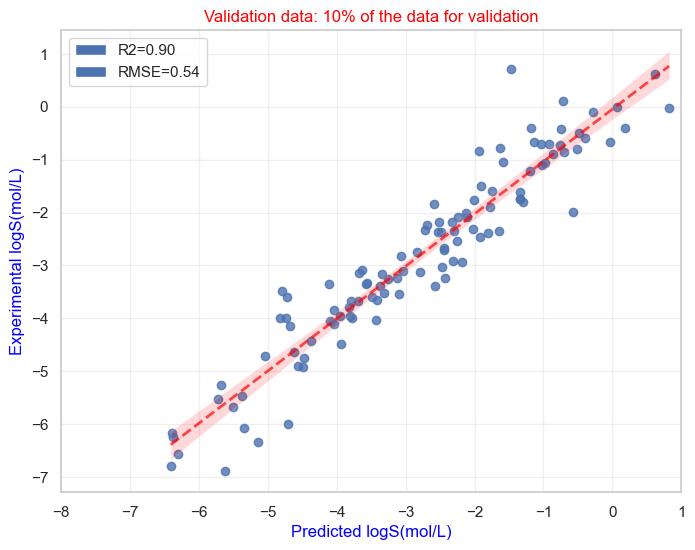

In [357]:
# Function call for plotting validation set
sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds,'Validation data: 10% of the data for validation')

In [358]:
pwd

'/Users/ajaniharesh'

In [359]:
test_set

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85
...,...,...,...,...,...,...
9938,C1664,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1.22,0.09,60.05
9939,C1665,HDZGCSFEDULWCS-UHFFFAOYSA-N,CNN,1.34,0.17,46.07
9940,C1666,OKKJLVBELUTLKV-UHFFFAOYSA-N,CO,1.57,-0.39,32.04
9941,C1667,DLFVBJFMPXGRIB-UHFFFAOYSA-N,CC(=O)N,1.58,0.19,59.07


In [360]:
# Null vaules for Smiles
test_set.SMILES.isnull().sum()

0

In [361]:
#remove Null Vaules
test_set.dropna(inplace=True)

In [362]:
test_set

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85
...,...,...,...,...,...,...
9938,C1664,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1.22,0.09,60.05
9939,C1665,HDZGCSFEDULWCS-UHFFFAOYSA-N,CNN,1.34,0.17,46.07
9940,C1666,OKKJLVBELUTLKV-UHFFFAOYSA-N,CO,1.57,-0.39,32.04
9941,C1667,DLFVBJFMPXGRIB-UHFFFAOYSA-N,CC(=O)N,1.58,0.19,59.07


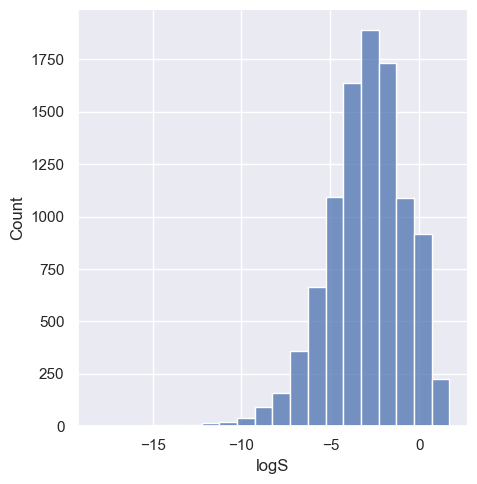

In [363]:
# Remove Outliers, which can not useful in ML
# Generate Histogram for LogS vaules distribution
sn.set_theme()
sn.displot(data=test_set, x="logS", binwidth=1)

<Axes: xlabel='logS'>

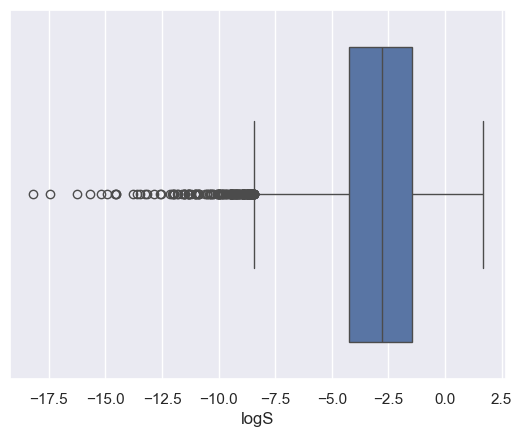

In [364]:
#Boxplot
sn.boxplot(data=test_set, x='logS')

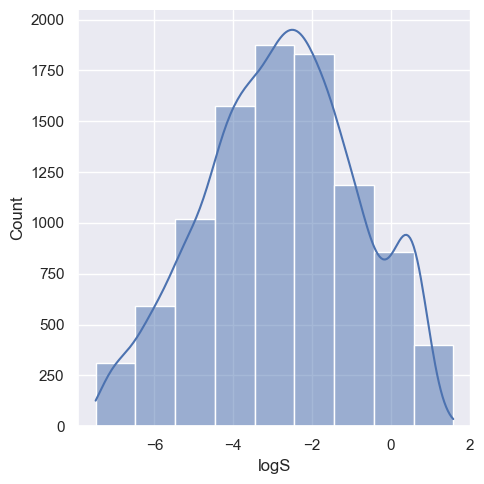

In [365]:
# Remove the outliers and filter the compounds that follow the normal distribution

test_set_new =test_set[test_set.logS.apply(lambda x:x> -7.5 and x< 1.7)]
sn.displot(data=test_set_new, x='logS', binwidth=1, kde=True)

<Axes: xlabel='logS'>

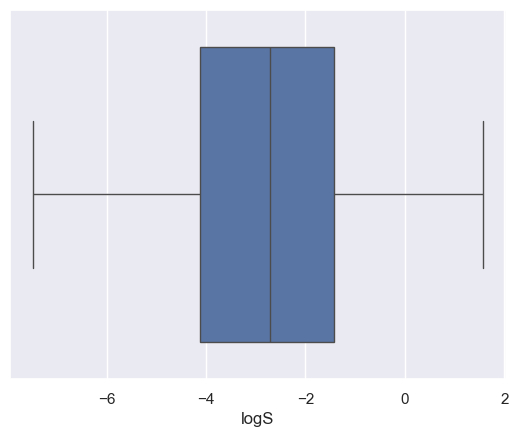

In [366]:
sn.boxplot(data=test_set_new, x='logS')

In [367]:
test_set_new

,Compound ID,InChIKey,SMILES,logS,logP,MW
294,C1951,NZFNXWQNBYZDAQ-UHFFFAOYSA-N,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1c(S2)cccc1.Cl,-7.49,6.69,407.04
295,C1952,CIMQMKORBAJNEC-UHFFFAOYSA-N,CC(=O)OCCN1CCN(CC1)CCCN1c2ccccc2Sc2c1cc(cc2)C(...,-7.49,6.42,552.48
296,C1953,MOPIFNSMNXBREW-UHFFFAOYSA-N,CCCCCCCNc1c2ccccc2nc2c1cccc2,-7.48,5.84,292.42
297,C1954,CKHJPWQVLKHBIH-ZDSKVHJSSA-N,O=CN(/C(=C(\SS/C(=C(\N(Cc1cnc(nc1N)C)C=O)/C)/C...,-7.47,7.12,702.89
298,C1955,NAPSCFZYZVSQHF-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCN(C)C,-7.46,6.81,297.56
...,...,...,...,...,...,...
9937,C9943,OGGXGZAMXPVRFZ-UHFFFAOYSA-N,C[As](=O)(O)C,1.16,0.11,138.00
9938,C1664,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1.22,0.09,60.05
9939,C1665,HDZGCSFEDULWCS-UHFFFAOYSA-N,CNN,1.34,0.17,46.07
9940,C1666,OKKJLVBELUTLKV-UHFFFAOYSA-N,CO,1.57,-0.39,32.04


In [368]:
# Remove the Duplicates Smiles or Structures

# generate canonical SMILES

def canonical_SMILES(smiles):
    canon_smi = [Chem.CanonSmiles(smi) for smi in smiles]
    return canon_smi

In [369]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(test_set_new.SMILES)

# Replace SMILES column wit Canonical SMILES
test_set_new["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = test_set_new[test_set_new['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

In [370]:
# Filter the duplicates smiles and sort them based on smiles

test_set_new[test_set_new['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


In [371]:
# Drop rows that contain duplicate SMILES and keep the first Structure
test_set_cleaned = test_set_new.drop_duplicates(subset=['SMILES'], keep='first')
len(test_set_cleaned)

9642

In [372]:
test_set_cleaned

,Compound ID,InChIKey,SMILES,logS,logP,MW
294,C1951,NZFNXWQNBYZDAQ-UHFFFAOYSA-N,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl,-7.49,6.69,407.04
295,C1952,CIMQMKORBAJNEC-UHFFFAOYSA-N,CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc...,-7.49,6.42,552.48
296,C1953,MOPIFNSMNXBREW-UHFFFAOYSA-N,CCCCCCCNc1c2ccccc2nc2ccccc12,-7.48,5.84,292.42
297,C1954,CKHJPWQVLKHBIH-ZDSKVHJSSA-N,C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C...,-7.47,7.12,702.89
298,C1955,NAPSCFZYZVSQHF-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCN(C)C,-7.46,6.81,297.56
...,...,...,...,...,...,...
9937,C9943,OGGXGZAMXPVRFZ-UHFFFAOYSA-N,C[As](C)(=O)O,1.16,0.11,138.00
9938,C1664,QTBSBXVTEAMEQO-UHFFFAOYSA-N,CC(=O)O,1.22,0.09,60.05
9939,C1665,HDZGCSFEDULWCS-UHFFFAOYSA-N,CNN,1.34,0.17,46.07
9940,C1666,OKKJLVBELUTLKV-UHFFFAOYSA-N,CO,1.57,-0.39,32.04


In [373]:
test_set_cleaned.shape

(9642, 6)

In [ ]:
#Calculate molecular descriptors for the test data or 9642 compounds
Mol_descriptors_test_set,desc_names_test_set = RDkit_descriptors(test_set_cleaned['SMILES'])
test_set_cleaned_with_210_descriptors = pd.DataFrame(Mol_descriptors_test_set,columns=desc_names_test_set)

  0%|                                                  | 0/9642 [00:00<?, ?it/s][23:07:27] DEPRECATION WARNING: please use MorganGenerator
[23:07:27] DEPRECATION WARNING: please use MorganGenerator
[23:07:27] DEPRECATION WARNING: please use MorganGenerator
[23:07:27] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1721395896353/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[23:07:27] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforge3/conda-bld/rdkit_1721395896353/work/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
****

[23:07:27] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 42 in file /Users/runner/miniforg

In [374]:
test_set_cleaned_with_210_descriptors.shape

(9642, 210)

In [375]:
# Standard scaler - transform
X_scaled_test = scaler.transform(test_set_cleaned_with_210_descriptors)

In [376]:
# Predict solubility of the test data
y_test_preds = model.predict(X_scaled_test)

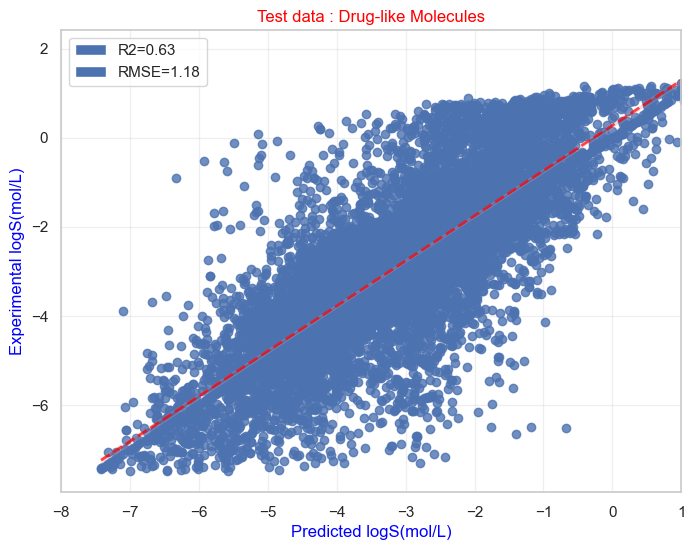

In [378]:
# function call for plotting testing set
sn.set_theme(style="whitegrid")
plot_data(test_set_cleaned['logS'], y_test_preds, 
           'Test data : Drug-like Molecules')